## Jon Stingel
#### this notebook is for importing metabolic data and train/testing simple regression models on

In [10]:
import os
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import scipy

%matplotlib inline
# pd.set_option('display.max_rows',None,'display.max_columns',None)


def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    temp = np.mean(np.abs((actual - pred) / actual)) * 100
    print(temp)
    print(temp.shape)
    return temp


In [11]:
## import the experimental values
# set paths
repobasedir = os.getcwd()
experimentalfile = os.path.join(repobasedir, 'experimentalMetabolics_all.csv')
# read in the file to dataframe
expmetcost_df = pd.read_csv(experimentalfile)
# print(expmetcost_df)

In [12]:
## import the simulation muscle metabolic values
# ## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
muscle_df.drop(['Row'],inplace=True,axis=1)
print('\ncheck if you want to drop this one value\n')
muscle_df.drop([40], inplace=True)
muscle_df.reset_index(inplace=True,drop=True)
# print(muscle_df)



check if you want to drop this one value



In [101]:
## import all of the grfs - X
# set all the paths
grffilespath = os.path.join(repobasedir,'..\\expfiles\\grffiles\\')
grffilelist = os.listdir(grffilespath)
# print(grffilelist)

muscle = 'metabolics_bifemlh_avg' # 'metabolics_recfem_avg','metabolics_sol_avg','metabolics_gas_avg'

# create dataframe
templist = []
temppeaklist = []
tempinteglist = []

for file in grffilelist:
    # load them into a dataframe
    tempsubj = file[0:7]
    tempcond = file[8:22]
    temptrial = file[23:-7]
    tempexp = file[0:4]
    tempfile = os.path.join(grffilespath,file)
    tempdata = pd.read_csv(tempfile, skiprows=6, delimiter='\t')
    # select the data we want
    temptime = tempdata['time'].to_numpy().reshape(-1,1)
    grfx = tempdata['ground_force_r_vx'].to_numpy().reshape(-1,1)
    grfy = tempdata['ground_force_r_vy'].to_numpy().reshape(-1,1)
    grfz = tempdata['ground_force_r_vz'].to_numpy().reshape(-1,1)
    
    # resample for a set size
    newgrfx, newtime = scipy.signal.resample(x=grfx, num=25, t=temptime)
    newgrfy = scipy.signal.resample(grfy, 25)
    newgrfz = scipy.signal.resample(grfz, 25)
    temp_df = pd.DataFrame({'subjectname':[tempsubj], 'condname':[tempcond],
                            'trialname':[temptrial], 'experimentname':[tempexp],
                            'grfy':[newgrfy]})
    templist.append(temp_df)
    
    # grab peak values
    peakx = max(grfx)
    peaky = max(grfy)
    peakz = max(grfz)
    temppeak_df = pd.DataFrame({'subjectname':[tempsubj], 'condname':[tempcond],
                                'trialname':[temptrial], 'experimentname':[tempexp],
                                'grfpeaks':[np.array([peakx, peaky, peakz])]})
    temppeaklist.append(temppeak_df)  

    # grab integral values
    tempintx = np.abs(grfx)
    tempinty = np.abs(grfy)
    tempintz = np.abs(grfz)
    integx = np.trapz(x=temptime, y=tempintx, axis=0)
    integy = np.trapz(x=temptime, y=tempinty, axis=0)
    integz = np.trapz(x=temptime, y=tempintz, axis=0)
    tempinteg_df = pd.DataFrame({'subjectname':[tempsubj], 'condname':[tempcond],
                                 'trialname':[temptrial], 'experimentname':[tempexp],
                                 'grfinteg':[np.array([integx, integy, integz])]})
    tempinteglist.append(tempinteg_df)

# end

    
    
## combine all the dataframes 
# curves - y
grfy_df = pd.concat(templist, ignore_index=True)
grfy_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
grfy_df.drop([40], inplace=True)
print('\nCheck if you want to drop the one subject14 trial in DEMB\n')
grfy_df.reset_index(inplace=True,drop=True)
# print(grfy_df)
# print(grfy_df['grfy'][0].shape)
# get X and Y now that everything is ordered
X_grfy = np.stack(grfy_df['grfy'])
X_grfy = X_grfy[:,:,0]
print(X_grfy.shape)
Y_grfy = muscle_df[muscle].values.reshape(-1,1)
print(Y_grfy.shape)

# peak x,y,z
grfpeak_df = pd.concat(temppeaklist, ignore_index=True)
grfpeak_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
grfpeak_df.drop([40], inplace=True)
print('\nCheck if you want to drop the one subject14 trial in DEMB\n')
grfpeak_df.reset_index(inplace=True, drop=True)
# print(grfpeak_df)
# print(grfpeak_df['grfpeaks'][0].shape)
X_peaks = np.stack(grfpeak_df['grfpeaks'])
X_peaks = X_peaks[:,:,0]
print(X_peaks.shape)
Y_peaks = muscle_df[muscle].values.reshape(-1,1)
print(Y_peaks.shape)

# integral x,y,z
grfinteg_df = pd.concat(tempinteglist, ignore_index=True)
grfinteg_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
grfinteg_df.drop([40], inplace=True)
print('\nCheck if you want to drop the one subject14 trial in DEMB\n')
grfinteg_df.reset_index(inplace=True, drop=True)
# print(grfinteg_df)
# print(grfinteg_df['grfinteg'][0].shape)
X_integ = np.stack(grfinteg_df['grfinteg'])
X_integ = X_integ[:,:,0]
print(X_integ.shape)
Y_integ = muscle_df[muscle].values.reshape(-1,1)
print(Y_integ.shape)


# fig1 = plt.figure()
# plt.plot(temptime, grfy)
# fig2 = plt.figure()
# plt.plot(newtime, newgrfy)

# fig31 = plt.figure()
# plt.plot(temptime, grfx)
# fig32 = plt.figure()
# plt.plot(temptime, grfy)
# fig33 = plt.figure()
# plt.plot(temptime, grfz)



Check if you want to drop the one subject14 trial in DEMB

(41, 25)
(41, 1)

Check if you want to drop the one subject14 trial in DEMB

(41, 3)
(41, 1)

Check if you want to drop the one subject14 trial in DEMB

(41, 3)
(41, 1)


mean: 3.659856
min:  0.930689
max:  8.492828
median: 2.930878


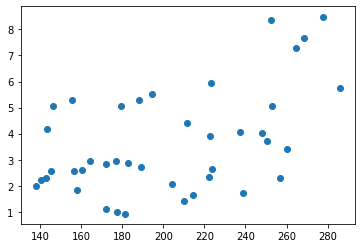

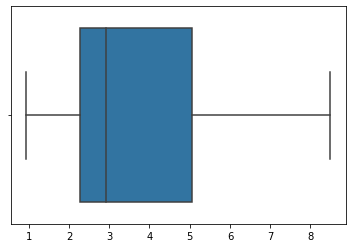

In [102]:
import seaborn as sns

fig = plt.figure()
plt.scatter(X_peaks[:,0],Y_integ)
# sns.set_theme(style="whitegrid")
fig2 = plt.figure()
ax = sns.boxplot(x=Y_peaks)
# ax = sns.swarmplot(x=Y_peaks)
# get some stats
muscle_mean = np.mean(Y_peaks)
muscle_min = np.min(Y_peaks)
muscle_max = np.max(Y_peaks)
muscle_med = np.median(Y_peaks)
print('mean: %f' % muscle_mean)
print('min:  %f' % muscle_min)
print('max:  %f' % muscle_max)
print('median: %f' % muscle_med)




RMSE training linear Reg.: 0.614063 W
RMSE test linear regression: 5.341725 W

Mean Absolute Error: 0.456920 W
Mean Absolute Error Test:  3.215706 W



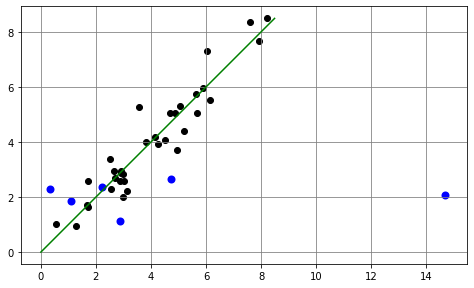

In [103]:
############################################################################
# linear regression model - curve y
############################################################################

# split into sets
split_by_subject = True
if split_by_subject:
    x_train_grfy_lg = X_grfy[0:30,:]
    temp = X_grfy[36:-1,:]
    x_train_grfy_lg = np.append(x_train_grfy_lg, temp, axis=0)
    y_train_grfy_lg = Y_grfy[0:30]
    temp2 = Y_grfy[36:-1]
    y_train_grfy_lg = np.append(y_train_grfy_lg, temp2, axis=0)
    x_test_grfy_lg = X_grfy[30:36,:]
    y_test_grfy_lg = Y_grfy[30:36]
else:
    x_train_grfy_lg,x_test_grfy_lg,y_train_grfy_lg,y_test_grfy_lg = train_test_split(X_grfy,Y_grfy,
                                                                                     test_size=0.15,
                                                                                    random_state=12)



reg_grfy = LinearRegression()
reg_grfy.fit(x_train_grfy_lg, y_train_grfy_lg)

# print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
y_pred_grfy = reg_grfy.predict(x_test_grfy_lg)
y_pred_grfy_train = reg_grfy.predict(x_train_grfy_lg)

# baseline error
mse_grfy_train = mean_squared_error(y_train_grfy_lg, y_pred_grfy_train)
rmse_grfy_train = np.sqrt(mse_grfy_train)
print('\nRMSE training linear Reg.: %f W' % rmse_grfy_train)

mse_grfy = mean_squared_error(y_test_grfy_lg,y_pred_grfy)
rmse_grfy = np.sqrt(mse_grfy)
print('RMSE test linear regression: %f W\n' % rmse_grfy)

# compute % error
mae_grfy_train_avg = mean_absolute_error(y_true=y_train_grfy_lg, y_pred=y_pred_grfy_train)
print('Mean Absolute Error: %f W' % mae_grfy_train_avg)

mae_grfy_test_avg = mean_absolute_error(y_true=y_test_grfy_lg, y_pred=y_pred_grfy)
print('Mean Absolute Error Test:  %f W\n' % mae_grfy_test_avg)


# print(y_test_grfy_lg)
# print(y_pred_grfy)

# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(y_pred_grfy_train, y_train_grfy_lg,
    c='black')
plt.scatter(y_pred_grfy, y_test_grfy_lg,
    c='blue',
    linewidth=2)
plt.grid(color='grey')

# generate unity line
unitx = np.linspace(0,max(Y_grfy),50)
unity = unitx
plt.plot(unitx,unity,'g-')

ax.set_aspect('equal')
# plt.xlim((0,35))
# plt.ylim((0,35))
plt.show()


RMSE training linear Reg.: 1.629050 W
RMSE linear regression: 2.325342 W

Mean Absolute Error Train: 1.292246 W
Mean Absolute Error Test:  2.238570 W



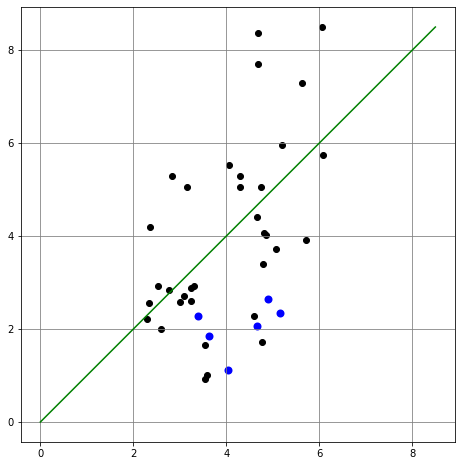

In [104]:
############################################################################
# linear regression model - peaks
############################################################################

# split into sets
split_by_subject = True
if split_by_subject:
    x_train_peaks_lg = X_peaks[0:30,:]
    temp = X_peaks[36:-1,:]
    x_train_peaks_lg = np.append(x_train_peaks_lg, temp, axis=0)
    y_train_peaks_lg = Y_peaks[0:30]
    temp2 = Y_peaks[36:-1]
    y_train_peaks_lg = np.append(y_train_peaks_lg, temp2, axis=0)
    x_test_peaks_lg = X_peaks[30:36,:]
    y_test_peaks_lg = Y_peaks[30:36]
else:
    x_train_peaks_lg,x_test_peaks_lg,y_train_peaks_lg,y_test_peaks_lg = train_test_split(X_peaks,Y_peaks,
                                                                                     test_size=0.15,
                                                                                    random_state=12)

# generate the linear regression model
reg_peaks = LinearRegression()
reg_peaks.fit(x_train_peaks_lg, y_train_peaks_lg)

# print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
y_pred_peaks = reg_peaks.predict(x_test_peaks_lg)
y_pred_peaks_train = reg_peaks.predict(x_train_peaks_lg)

# baseline error
mse_peaks_train = mean_squared_error(y_train_peaks_lg, y_pred_peaks_train)
rmse_peaks_train = np.sqrt(mse_peaks_train)
print('\nRMSE training linear Reg.: %f W' % rmse_peaks_train)

mse_peaks = mean_squared_error(y_test_peaks_lg,y_pred_peaks)
rmse_peaks = np.sqrt(mse_peaks)
print('RMSE linear regression: %f W\n' % rmse_peaks)

# compute % error
mae_peaks_train_avg = mean_absolute_error(y_true=y_train_peaks_lg, y_pred=y_pred_peaks_train)
print('Mean Absolute Error Train: %f W' % mae_peaks_train_avg)

mae_peaks_test_avg = mean_absolute_error(y_true=y_test_peaks_lg, y_pred=y_pred_peaks)
print('Mean Absolute Error Test:  %f W\n' % mae_peaks_test_avg)


# print(y_test_peaks_lg)
# print(y_pred_peaks)

# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(y_pred_peaks_train, y_train_peaks_lg,
    c='black')
plt.scatter(y_pred_peaks, y_test_peaks_lg,
    c='blue',
    linewidth=2)
plt.grid(color='grey')

# generate unity line
unitx = np.linspace(0,max(Y_grfy),50)
unity = unitx
plt.plot(unitx,unity,'g-')

ax.set_aspect('equal')
# plt.xlim((0,35))
# plt.ylim((0,35))
plt.show()


RMSE training linear Reg.: 1.762576 W
RMSE linear regression: 3.457777 W

Mean Absolute Error Train: 1.485085 W
Mean Absolute Error Test: 3.278118 W



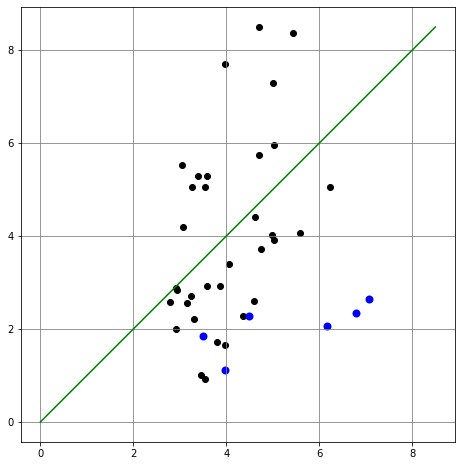

In [105]:
############################################################################
# linear regression model - integ
############################################################################

# split into sets
split_by_subject = True
if split_by_subject:
    x_train_integ_lg = X_integ[0:30,:]
    temp = X_integ[36:-1,:]
    x_train_integ_lg = np.append(x_train_integ_lg, temp, axis=0)
    y_train_integ_lg = Y_integ[0:30]
    temp2 = Y_integ[36:-1]
    y_train_integ_lg = np.append(y_train_integ_lg, temp2, axis=0)
    x_test_integ_lg = X_integ[30:36,:]
    y_test_integ_lg = Y_integ[30:36]
else:
    x_train_integ_lg,x_test_integ_lg,y_train_integ_lg,y_test_integ_lg = train_test_split(X_integ,Y_integ,
                                                                                     test_size=0.15,
                                                                                    random_state=12)

# generate the linear regression model
reg_integ = LinearRegression()
reg_integ.fit(x_train_integ_lg, y_train_integ_lg)

# print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
y_pred_integ = reg_integ.predict(x_test_integ_lg)
y_pred_integ_train = reg_integ.predict(x_train_integ_lg)

# baseline error
mse_integ_train = mean_squared_error(y_train_integ_lg, y_pred_integ_train)
rmse_integ_train = np.sqrt(mse_integ_train)
print('\nRMSE training linear Reg.: %f W' % rmse_integ_train)

mse_integ = mean_squared_error(y_test_integ_lg,y_pred_integ)
rmse_integ = np.sqrt(mse_integ)
print('RMSE linear regression: %f W\n' % rmse_integ)

# compute % error
mae_integ_train_avg = mean_absolute_error(y_true=y_train_integ_lg, y_pred=y_pred_integ_train)
print('Mean Absolute Error Train: %f W' % mae_integ_train_avg)

mae_integ_test_avg = mean_absolute_error(y_true=y_test_integ_lg, y_pred=y_pred_integ)
print('Mean Absolute Error Test: %f W\n' % mae_integ_test_avg)

# print(y_test_integ_lg)
# print(y_pred_integ)

# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(y_pred_integ_train, y_train_integ_lg,
    c='black')
plt.scatter(y_pred_integ, y_test_integ_lg,
    c='blue',
    linewidth=2)
plt.grid(color='grey')

# generate unity line
unitx = np.linspace(0,max(Y_grfy),50)
unity = unitx
plt.plot(unitx,unity,'g-')

ax.set_aspect('equal')
# plt.xlim((0,35))
# plt.ylim((0,35))
plt.show()


RMSE training .: 0.650772 W
RMSE test : 0.544599 W

Mean Absolute Error Train: 0.472086 W
Mean Absolute Error Test: 0.498266 W

-0.2631092975536884


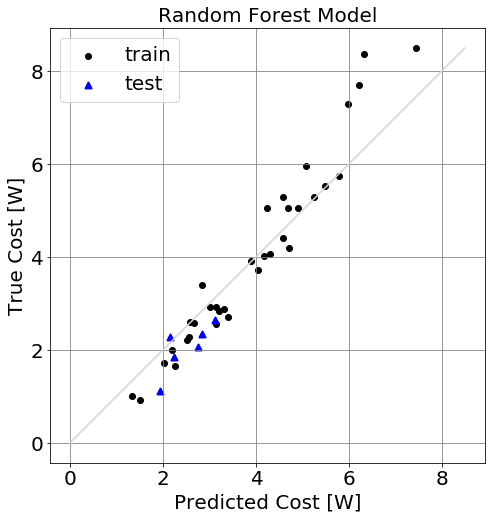

In [106]:
############################################################################
# random forest model - curve y
############################################################################

# split into sets
split_by_subject = True
if split_by_subject:
    x_train_grfy_rf = X_grfy[0:30,:]
    temp = X_grfy[36:-1,:]
    x_train_grfy_rf = np.append(x_train_grfy_rf, temp, axis=0)
    y_train_grfy_rf = Y_grfy[0:30]
    temp2 = Y_grfy[36:-1]
    y_train_grfy_rf = np.append(y_train_grfy_rf, temp2, axis=0)
    x_test_grfy_rf = X_grfy[30:36,:]
    y_test_grfy_rf = Y_grfy[30:36]
else:
    x_train_grfy_rf,x_test_grfy_rf,y_train_grfy_rf,y_test_grfy_rf = train_test_split(X_grfy,Y_grfy,
                                                                                     test_size=0.15,
                                                                                    random_state=12)



ranfor_grfy = RandomForestRegressor(random_state=13, n_estimators=100)
ranfor_grfy.fit(x_train_grfy_rf, y_train_grfy_rf[:,0])

# print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
y_pred_grfy_rf = ranfor_grfy.predict(x_test_grfy_rf)
y_pred_grfy_train_rf = ranfor_grfy.predict(x_train_grfy_rf)

# baseline error
mse_grfy_train_rf = mean_squared_error(y_train_grfy_rf, y_pred_grfy_train_rf)
rmse_grfy_train_rf = np.sqrt(mse_grfy_train_rf)
print('\nRMSE training .: %f W' % rmse_grfy_train_rf)

mse_grfy_rf = mean_squared_error(y_test_grfy_rf,y_pred_grfy_rf)
rmse_grfy_rf = np.sqrt(mse_grfy_rf)
print('RMSE test : %f W\n' % rmse_grfy_rf)

# compute % error
mae_grfy_train_avg_rf = mean_absolute_error(y_true=y_train_grfy_rf, y_pred=y_pred_grfy_train_rf)
print('Mean Absolute Error Train: %f W' % mae_grfy_train_avg_rf)

mae_grfy_test_avg_rf = mean_absolute_error(y_true=y_test_grfy_rf, y_pred=y_pred_grfy_rf)
print('Mean Absolute Error Test: %f W\n' % mae_grfy_test_avg_rf)

print(r2_score(y_true=y_test_grfy_rf, y_pred=y_pred_grfy_rf))
# print(y_test_grfy_lg)
# print(y_pred_grfy)

# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(y_pred_grfy_train_rf, y_train_grfy_rf,
    c='black', label='train')
plt.scatter(y_pred_grfy_rf, y_test_grfy_rf,
    c='blue',
    linewidth=2, marker='^', label='test')
plt.grid(color='grey')
plt.legend(fontsize=20)
# generate unity line
unitx = np.linspace(0,max(Y_grfy),50)
unity = unitx
plt.plot(unitx,unity,color='lightgrey')
plt.xlabel('Predicted Cost [W]', fontsize=20)
plt.ylabel('True Cost [W]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_aspect('equal')
plt.title('Random Forest Model', fontsize=20)

plt.savefig('bflh_randomforest_ycurve.png', dpi=600)
# plt.xlim((0,35))
# plt.ylim((0,35))
plt.show()

In [9]:
#######################################################
## single decision tree implementation
X_dt = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_dt = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt,Y_dt,test_size=0.15,random_state=12)
x_train_dt = X_dt[0:30,:]
temp = X_dt[36:-1,:]
x_train_dt = np.append(x_train_dt, temp, axis=0)
y_train_dt = Y_dt[0:30,:]
temp2 = Y_dt[36:-1,:]
y_train_dt = np.append(y_train_dt, temp2, axis=0)
x_test_dt = X_dt[30:36,:]
y_test_dt = Y_dt[30:36,:]

print(x_train_dt.shape)
print(y_train_dt.shape)
print(x_test_dt.shape)
print(y_test_dt.shape)

# x_train = x_train.reshape(-1,)
y_train_dt = y_train_dt.reshape(-1,)
# x_test_dt = x_test_dt.reshape(-1,)
y_test_dt = y_test_dt.reshape(-1,)
# print(x_train_dt.shape)
# print(y_train_dt.shape)

DecisionTreeRegModel = DecisionTreeRegressor(random_state=13)
DecisionTreeRegModel.fit(x_train_dt, y_train_dt)



NameError: name 'bothtrim_df' is not defined

In [ ]:
# try some predictions
print('y_test_dt:')
print(y_test_dt)
y_pred_dt = DecisionTreeRegModel.predict(x_test_dt)
print('y_pred_dt:')
print(y_pred_dt)

# error
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print('\nRMSE: %f' % rmse_dt)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_dt,y_test_dt,
    c='black', label='Umberger model')
plt.scatter(y_pred_dt, y_test_dt,
    c='blue', label='Single Decision Tree')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [ ]:
########################################################
## random forest implementation

X_rf = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_rf = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf,Y_rf,test_size=0.15,random_state=12)
x_train_rf = X_rf[0:30,:]
temp = X_rf[36:-1,:]
x_train_rf = np.append(x_train_rf, temp, axis=0)
y_train_rf = Y_rf[0:30,:]
temp2 = Y_rf[36:-1,:]
y_train_rf = np.append(y_train_rf, temp2, axis=0)
x_test_rf = X_rf[30:36,:]
y_test_rf = Y_rf[30:36,:]




# x_train_rf = x_train_rf.reshape(-1,)
y_train_rf = y_train_rf.reshape(-1,)
# x_test_rf = x_test_rf.reshape(-1,)
y_test_rf = y_test_rf.reshape(-1,)
# print(x_train_rf.shape)
# print(y_train_rf.shape)

RandomForestRegModel = RandomForestRegressor(random_state=13)
RandomForestRegModel.fit(x_train_rf, y_train_rf)



In [ ]:
# try some predictions
print('y_test_rf:')
print(y_test_rf)
y_pred_rf = RandomForestRegModel.predict(x_test_rf)
print('y_pred_rf:')
print(y_pred_rf)

# error
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('\nRMSE: %f' % rmse_rf)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_rf,y_test_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_rf, y_test_rf,
    c='blue', label='Random Forest')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Getting X  values with all the umberger components

In [ ]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
muscle_df.drop(['Row'],inplace=True,axis=1)
muscle_df.reset_index(inplace=True,drop=True)
# print(muscle_df)

In [ ]:
# figure out how to pair down the experimental to only have these ones
combos = []
for index, row in muscle_df.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    combos.append((subj,cond,trial))
combosunique = set(combos)
# print(combosunique)

idk = pd.merge(expmetcost_df, muscle_df, how='left', indicator=True)
idk2 = idk.reset_index()

indextodrop = []
for index, row in idk2.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    if (subj,cond,trial) not in combosunique:
        indextodrop.append(index)

idk3 = idk2.drop(indextodrop)
# print(idk3)
idk4 = idk3.drop(['index','_merge','metabolics_mech_avg','metabolics_basal_avg','metabolics_short_avg','metabolics_act_avg'], axis=1)
# print(idk4)
# sort the dataframe TODO sort the sims one the same way
idk5 = idk4.sort_values(by=['subjectname','condname','trialname'])
idk5.reset_index(inplace=True,drop=True)

exp_df = idk5
# print(exp_df)


## random forest for all umberger inputs

In [ ]:
# set up the X and Y
X_multi_rf = muscle_df.iloc[:,0:5].values
# print(X_multi_rf)
Y_multi_rf = exp_df.iloc[:,0].values
# print(Y_multi_rf)

# split into sets
# x_train_multi_rf,x_test_multi_rf,y_train_multi_rf,y_test_multi_rf = train_test_split(X_multi_rf,Y_multi_rf,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_rf = X_multi_rf[0:30,:]
temp = X_multi_rf[36:-1,:]
x_train_multi_rf = np.append(x_train_multi_rf, temp, axis=0)
y_train_multi_rf = Y_multi_rf[0:30]
temp2 = Y_multi_rf[36:-1]
y_train_multi_rf = np.append(y_train_multi_rf, temp2, axis=0)
x_test_multi_rf = X_multi_rf[30:36,:]
y_test_multi_rf = Y_multi_rf[30:36]




# print(X_multi_rf.shape)
# print(Y_multi_rf.shape)

print(x_train_multi_rf.shape)
print(y_train_multi_rf.shape)
print(x_test_multi_rf.shape)
print(y_test_multi_rf.shape)

multiregrf = RandomForestRegressor(random_state=13)
multiregrf.fit(x_train_multi_rf,y_train_multi_rf)
y_pred_multi_rf = multiregrf.predict(x_test_multi_rf)
y_pred_multi_rf_train = multiregrf.predict(x_train_multi_rf)


In [ ]:
# try some predictions
print('y_test_multi_rf:')
print(y_test_multi_rf)
print('y_pred_rf:')
print(y_pred_multi_rf)

# error
mse_multi_rf_base = mean_squared_error(Y_multi_rf,X_multi_rf[:,0])
rmse_multi_rf_base = np.sqrt(mse_multi_rf_base)
print('\nRMSE baseline: %f' % rmse_multi_rf_base)

mse_multi_rf_train = mean_squared_error(y_train_multi_rf, y_pred_multi_rf_train)
rmse_multi_rf_train = np.sqrt(mse_multi_rf_train)
print('\nRMSE training: %f' % rmse_multi_rf_train)

mse_multi_rf = mean_squared_error(y_test_multi_rf, y_pred_multi_rf)
rmse_multi_rf = np.sqrt(mse_multi_rf)
print('\nRMSE test: %f' % rmse_multi_rf)

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_rf[:,0],y_train_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_train, y_train_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_rf[:,0],y_test_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf, y_test_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()